In [110]:
import re
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import recall_score, classification_report, confusion_matrix, precision_score, f1_score, roc_curve, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor

In [111]:
df_pred = pd.read_csv("C:/Users/LENOVO/Desktop/Patient-Satisfaction-and-Characteristics-in-Psychiatric-Hospitals-2017-1/data/processed/data_ready_to_predict_without_outliers.csv")

# Perform all column name modifications at once
df_pred.columns = [
    re.sub(r'\s+', '_', col)  # Replacing spaces with `_`
    .replace('\xa0', '_')  # Removing invisible spaces
    .replace('(', '')  # Removing left parentheses
    .replace(')', '')  # Removing right parentheses
    .replace("'", '')  # Removing single quotes
    .replace('"', '')  # Removing double quotes (for additional cases)
    .replace('[','').replace(']','').replace('<','').replace('>','')  # Removing square brackets and special characters
    .replace('.','')  # Removing periods
    .replace('–','_')  # Removing non-standard hyphens and replacing them with `_`
    .replace('-','')  # Removing hyphens
    .replace('__', '_')  # Preventing double underscores
    for col in df_pred.columns
]

# Re-checking if there are any invalid columns
print([col for col in df_pred.columns if not col.isidentifier()])

df_pred.head()

[]


,id,migdar,migdarmachlaka,sugmachlaka,mitot,hosp_num,num_of_days_until_now,num_of_days_to_release,total_hosp_time,age,...,q42_1,q42_2,q42_11,q42_21,q43_1,q43_2,q43_3,q44_1,q44_2,q44_3
0,129600,2,3,1,298,3.0,23.0,5.0,28.0,37.0,...,1,0,0,0,0,1,0,0,1,0
1,129602,1,3,1,298,3.0,30.0,5.0,35.0,23.0,...,1,0,0,0,0,1,0,0,1,0
2,129603,2,3,1,298,3.0,26.0,5.0,31.0,23.0,...,1,0,0,0,0,1,0,0,1,0
3,129605,1,3,1,298,3.0,13.0,0.0,13.0,35.0,...,1,0,0,0,0,1,0,0,1,0
4,129606,1,3,1,298,3.0,36.0,5.0,41.0,43.0,...,1,0,0,0,0,1,0,0,0,1


Cross-Validation Accuracy Scores: [0.647343   0.64563107 0.65048544 0.65048544 0.60679612]
Mean Accuracy: 0.64 ± 0.02

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.75      0.70       585
           1       0.60      0.50      0.55       446

    accuracy                           0.64      1031
   macro avg       0.63      0.62      0.62      1031
weighted avg       0.64      0.64      0.63      1031

Hit Ratio for Survey Responses (within ±0.1): 64.02%


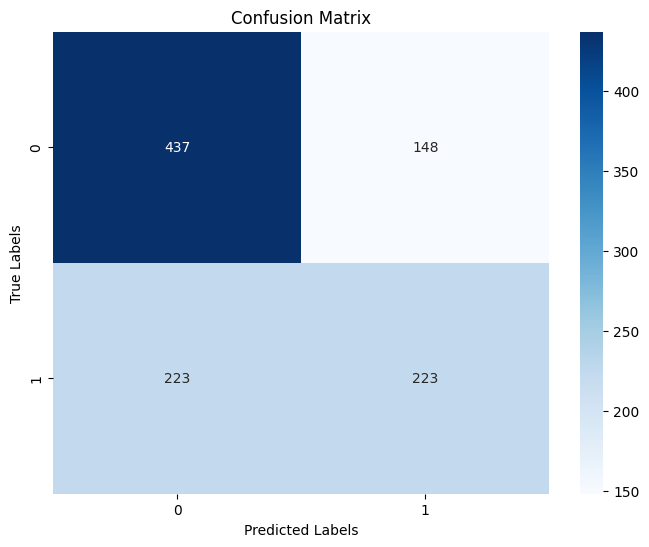

In [3]:
def RandomForestClusterPredictor(df, k=5):
    # Columns unrelated to predicting the cluster type
    survey_columns = ['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9',
                      'q10', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17', 'q18', 
                      'q19', 'q20', 'q21', 'q22', 'q23', 'q24', 'q25', 'q26', 
                      'q27', 'q28', 'q29', 'q30', 'q31', 'q33', 'q34', 'q35', 
                      'q36', 'q37', 'q71', 'q72', 'q73', 'q74', 'q75', 'q76', 'forced_during_agreed']
    
    # Separate feature variables (X) and target (y)
    X = df.drop(columns=survey_columns + ["kmeans_cluster"])  
    y = df["kmeans_cluster"]  

    # Define K-Fold Cross Validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Create the model
    classifier = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None)
    
    # Calculate accuracy with Cross Validation
    accuracy_scores = cross_val_score(classifier, X, y, cv=kf, scoring='accuracy')
    
    print(f"Cross-Validation Accuracy Scores: {accuracy_scores}")
    print(f"Mean Accuracy: {np.mean(accuracy_scores):.2f} ± {np.std(accuracy_scores):.2f}")
    
    # Run cross_val_predict to get *individual* predictions for each fold
    y_pred = cross_val_predict(classifier, X, y, cv=kf)

    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    
    # Calculate the hit ratio
    tolerance = 0.1  
    accurate_predictions = np.abs(y - y_pred) <= tolerance
    hit_ratio = np.mean(accurate_predictions) * 100  
    print(f"Hit Ratio for Survey Responses (within ±{tolerance}): {hit_ratio:.2f}%")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


RandomForestClusterPredictor(df_pred, k=5)



# Why Random Forest Regressor?

## Suitability
The **RandomForestRegressor** is a great choice for predicting survey responses because it can handle:
- **Non-linear relationships**: Random forests can capture complex interactions between features and outputs.
- **Multi-output regression**: It supports predicting multiple continuous outputs simultaneously, which matches the need for forecasting survey responses.

## Advantages
1. **Robustness to Noise**: Random forests are less sensitive to outliers or noisy data due to their ensemble nature.
2. **Feature Importance**: The model provides insight into which features are most relevant for the predictions.
3. **Scalability**: It performs well on datasets with many features and samples.
4. **No Need for Scaling**: Unlike other models, random forests don't require data normalization or scaling.

## Disadvantages
1. **Resource Intensive**: Training can be computationally expensive for large datasets.
2. **Interpretability**: While feature importance is available, the overall model can be harder to interpret compared to simpler models.

In this project, **RandomForestRegressor** works well for predicting survey responses (continuous outputs), complementing the binary classification task in multi-task learning setups.


In [ ]:
def LinearRegression_MultiOutput(df, k=5):
    # --- Step 1: Define the columns ---
    survey_columns = ['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9',
                      'q10', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17', 'q18', 
                      'q19', 'q20', 'q21', 'q22', 'q23', 'q24', 'q25', 'q26', 
                      'q27', 'q28', 'q29', 'q30', 'q31', 'q33', 'q34', 'q35', 
                      'q36', 'q37', 'q71', 'q72', 'q73', 'q74', 'q75', 'q76', 'forced_during_agreed']

    # --- Step 2: Prepare the data ---
    X = df.drop(columns=survey_columns + ["kmeans_cluster"])  
    y = df["kmeans_cluster"].values.reshape(-1, 1)  

    # Define K-Fold Cross Validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Create the model
    model = MultiOutputRegressor(LinearRegression())

    # Prediction with Cross Validation
    y_pred = cross_val_predict(model, X, y, cv=kf)

    # --- Step 4: Evaluate performance ---
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    print("Linear Regression MultiOutput Results (Cross-Validation):")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")

In [5]:
LinearRegression_MultiOutput(df_pred)

Linear Regression MultiOutput Results (Cross-Validation):
Mean Squared Error: 0.2298
R² Score: 0.0639


In [ ]:
def Logistic_Regression_Classifier(df, k=5):
    # --- Step 1: Define columns ---
    survey_columns = ['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9',
                      'q10', 'q12', 'q13', 'q14','q15', 'q16', 'q17', 'q18', 'q19',
                      'q20', 'q21', 'q22', 'q23', 'q24', 'q25', 'q26', 'q27','q28', 'q29',
                      'q30','q31', 'q33', 'q34', 'q35', 'q36', 'q37', 'q71', 'q72', 'q73', 'q74',
                      'q75', 'q76', 'forced_during_agreed']

    # --- Step 2: Prepare the data ---
    X = df.drop(columns=survey_columns + ["kmeans_cluster"])  # General features
    y = df["kmeans_cluster"]  # Cluster type

    # --- Step 3: Normalize the data ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # --- Step 4: Define the model ---
    class_weight = {0: 2, 1: 3}  # Change class 1 weight to make it "heavier"
    model = LogisticRegression(random_state=42, max_iter=1000, class_weight=class_weight)

    # --- Step 5: Define K-Fold Cross Validation ---
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    recall_scores = []  # We will store recall scores for each fold

    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model on each fold
        model.fit(X_train, y_train)

        # Prediction on the current fold
        y_pred = model.predict(X_test)

        # Calculate and print classification report and confusion matrix for each fold
        print("Classification Report (Cross-Validation):")
        print(classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)
        print("Confusion Matrix (Cross-Validation):")
        print(cm)

        accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
        print(f"Accuracy (Cross-Validation): {accuracy:.2f}")

        # Save the recall for class 1 for each fold
        recall_class_1 = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) != 0 else 0
        recall_scores.append(recall_class_1)

    # --- Step 6: Calculate average recall across all folds ---
    avg_recall = np.mean(recall_scores)
    print(f"Average Recall across all folds: {avg_recall:.2f}")

In [62]:
Logistic_Regression_Classifier(df_pred, k=5)

Classification Report (Cross-Validation):
              precision    recall  f1-score   support

           0       0.71      0.62      0.66       120
           1       0.55      0.64      0.60        87

    accuracy                           0.63       207
   macro avg       0.63      0.63      0.63       207
weighted avg       0.64      0.63      0.64       207

Confusion Matrix (Cross-Validation):
[[75 45]
 [31 56]]
Accuracy (Cross-Validation): 0.63
Classification Report (Cross-Validation):
              precision    recall  f1-score   support

           0       0.68      0.64      0.66       109
           1       0.62      0.66      0.64        97

    accuracy                           0.65       206
   macro avg       0.65      0.65      0.65       206
weighted avg       0.65      0.65      0.65       206

Confusion Matrix (Cross-Validation):
[[70 39]
 [33 64]]
Accuracy (Cross-Validation): 0.65
Classification Report (Cross-Validation):
              precision    recall  f1-sc

In [109]:
def Decision_Tree_Classifier(df, k=5):
    # --- Step 1: Define columns ---
    survey_columns = ['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9',
                      'q10', 'q12', 'q13', 'q14','q15', 'q16', 'q17', 'q18', 'q19',
                      'q20', 'q21', 'q22', 'q23', 'q24', 'q25', 'q26', 'q27','q28', 'q29',
                      'q30','q31', 'q33', 'q34', 'q35', 'q36', 'q37', 'q71', 'q72', 'q73', 'q74',
                      'q75', 'q76', 'forced_during_agreed']

    # --- Step 2: Prepare the data ---
    X = df.drop(columns=survey_columns + ["kmeans_cluster"])  # General features
    y = df["kmeans_cluster"]  # Cluster type

    # Handling missing values
    X = X.fillna(0)

    # Convert boolean values to 0 and 1 if present
    X = X.astype(int)

    # --- Step 3: Normalize the data ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # --- Step 4: Define the model ---
    model = DecisionTreeClassifier(
        criterion="gini",   # or "entropy"
        max_depth=5,        # Maximum depth of the tree
        random_state=42
    )

    # --- Step 5: Define K-Fold Cross Validation ---
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    recall_scores = []  # List to store Recall
    precision_scores = []  # List to store Precision
    f1_scores = []  # List to store F1

    for fold_idx, (train_index, test_index) in enumerate(kf.split(X_scaled)):
        print(f"Training on Fold {fold_idx+1}/{k}...")

        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model on each fold
        model.fit(X_train, y_train)

        # Prediction on the current fold
        y_pred = model.predict(X_test)

        # Calculate the metrics
        recall_class_1 = recall_score(y_test, y_pred, pos_label=1)
        precision_class_1 = precision_score(y_test, y_pred, pos_label=1)
        f1_class_1 = f1_score(y_test, y_pred)

        # Save the metrics
        recall_scores.append(recall_class_1)
        precision_scores.append(precision_class_1)
        f1_scores.append(f1_class_1)

        print(f"Fold {fold_idx+1} - Recall: {recall_class_1:.2f}, Precision: {precision_class_1:.2f}, F1: {f1_class_1:.2f}")

    # --- Step 6: Calculate the average metrics across all folds ---
    avg_recall = np.mean(recall_scores)
    avg_precision = np.mean(precision_scores)
    avg_f1 = np.mean(f1_scores)

    print("\n📊 Average metrics across all folds:")
    print(f"Average Recall: {avg_recall:.2f}")
    print(f"Average Precision: {avg_precision:.2f}")
    print(f"Average F1-Score: {avg_f1:.2f}")

    return model  # Returns the last trained model

Decision_Tree_Classifier(df_pred)

Training on Fold 1/5...
Fold 1 - Recall: 0.61, Precision: 0.60, F1: 0.60
Training on Fold 2/5...
Fold 2 - Recall: 0.41, Precision: 0.58, F1: 0.48
Training on Fold 3/5...
Fold 3 - Recall: 0.49, Precision: 0.55, F1: 0.52
Training on Fold 4/5...
Fold 4 - Recall: 0.37, Precision: 0.58, F1: 0.45
Training on Fold 5/5...
Fold 5 - Recall: 0.44, Precision: 0.52, F1: 0.47

📊 ממוצע המדדים על פני כל הקיפולים:
Average Recall: 0.46
Average Precision: 0.57
Average F1-Score: 0.51


DecisionTreeClassifier(max_depth=5, random_state=42)

In [104]:
def SVM_Classifier_Optimized(df, k=5):
    survey_columns = ['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9',
                      'q10', 'q12', 'q13', 'q14','q15', 'q16', 'q17', 'q18', 'q19',
                      'q20', 'q21', 'q22', 'q23', 'q24', 'q25', 'q26', 'q27','q28', 'q29',
                      'q30','q31', 'q33', 'q34', 'q35', 'q36', 'q37', 'q71', 'q72', 'q73', 'q74',
                      'q75', 'q76', 'forced_during_agreed']

    # --- Step 1: Prepare the data ---
    X = df.drop(columns=survey_columns + ["kmeans_cluster"])
    y = df["kmeans_cluster"]

    # Handling missing values
    X = X.fillna(0)
    X = X.astype(int)

    # --- Step 2: Define K-Fold Cross Validation ---
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    recall_scores = []
    precision_scores = []
    f1_scores = []

    # --- Step 3: Calculate probability predictions for each fold ---
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"Training on Fold {fold_idx+1}/{k}...")

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # --- Step 4: Build the model ---
        model = SVC(
            kernel="rbf", 
            class_weight="balanced", 
            probability=True, 
            random_state=42
        )
        model.fit(X_train, y_train)

        # --- Step 5: Predict probabilities ---
        y_pred_prob = model.predict_proba(X_test)[:, 1]

        # --- Step 6: Calculate ROC Curve and optimize decision threshold ---
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        optimal_idx = (tpr - fpr).argmax()  # Max TPR - FPR
        optimal_threshold = thresholds[optimal_idx]
        print(f"Optimal Threshold for Fold {fold_idx+1}: {optimal_threshold:.2f}")

        # --- Step 7: Predict again with the optimized threshold ---
        y_pred = (y_pred_prob >= optimal_threshold).astype(int)

        # --- Step 8: Evaluate performance ---
        recall_class_1 = recall_score(y_test, y_pred, pos_label=1)
        precision_class_1 = precision_score(y_test, y_pred, pos_label=1)
        f1_class_1 = f1_score(y_test, y_pred)

        recall_scores.append(recall_class_1)
        precision_scores.append(precision_class_1)
        f1_scores.append(f1_class_1)

        print(f"Fold {fold_idx+1} - Recall: {recall_class_1:.2f}, Precision: {precision_class_1:.2f}, F1: {f1_class_1:.2f}")

    # --- Step 9: Calculate average metrics ---
    avg_recall = np.mean(recall_scores)
    avg_precision = np.mean(precision_scores)
    avg_f1 = np.mean(f1_scores)

    print("\n📊 Average metrics across all folds:")
    print(f"Average Recall: {avg_recall:.2f}")
    print(f"Average Precision: {avg_precision:.2f}")
    print(f"Average F1-Score: {avg_f1:.2f}")

    return model  # Returns the last trained model

# Function call
SVM_Classifier_Optimized(df_pred, k=5)

Training on Fold 1/5...
Optimal Threshold for Fold 1: 0.42
Fold 1 - Recall: 0.37, Precision: 0.49, F1: 0.42
Training on Fold 2/5...
Optimal Threshold for Fold 2: 0.45
Fold 2 - Recall: 0.84, Precision: 0.52, F1: 0.64
Training on Fold 3/5...
Optimal Threshold for Fold 3: 0.46
Fold 3 - Recall: 0.50, Precision: 0.47, F1: 0.49
Training on Fold 4/5...
Optimal Threshold for Fold 4: 0.39
Fold 4 - Recall: 0.08, Precision: 0.78, F1: 0.14
Training on Fold 5/5...
Optimal Threshold for Fold 5: 0.40
Fold 5 - Recall: 0.54, Precision: 0.47, F1: 0.51

📊 ממוצע המדדים על פני כל הקיפולים:
Average Recall: 0.46
Average Precision: 0.55
Average F1-Score: 0.44


SVC(class_weight='balanced', probability=True, random_state=42)

In [88]:
def lightGBM_classifier_bestThreshold(df):
    # --- Step 1: Column Definitions ---
    survey_columns = ['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9',
                      'q10', 'q12', 'q13', 'q14','q15', 'q16', 'q17', 'q18', 'q19',
                      'q20', 'q21', 'q22', 'q23', 'q24', 'q25', 'q26', 'q27','q28', 'q29',
                      'q30','q31', 'q33', 'q34', 'q35', 'q36', 'q37', 'q71', 'q72', 'q73', 'q74',
                      'q75', 'q76', 'forced_during_agreed']

    # --- Step 2: Data Preparation ---
    X = df.drop(columns=survey_columns + ["kmeans_cluster"])  # General features
    y = df["kmeans_cluster"]  # Cluster type

    # Splitting the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # --- Step 3: Building the model with scale_pos_weight ---
    pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])  # Class ratio

    model = lgb.LGBMClassifier(
        objective='binary', 
        n_estimators=100,        # Number of trees
        random_state=42,         # Random seed
        class_weight='balanced', # Adjusting class weights
        scale_pos_weight=pos_weight  # Weight for class 1
    )

    model.fit(X_train, y_train)

    # --- Step 4: Prediction ---
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

    # --- Step 5: Searching for the optimal threshold ---
    best_threshold = 0.5
    best_f1 = 0
    
    thresholds = np.arange(0.1, 0.9, 0.05)  # Testing thresholds between 0.1 and 0.9
    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print(f"Threshold: {threshold:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1 Score: {f1:.2f}")
        
        if f1 > best_f1:  # If the F1 Score is better, save the threshold
            best_f1 = f1
            best_threshold = threshold

    print(f"\n🔹 **Best Threshold: {best_threshold:.2f} with F1 Score: {best_f1:.2f}**")

    return best_threshold  # Returning the optimal threshold

print(lightGBM_classifier_bestThreshold(df_pred))


[LightGBM] [Info] Number of positive: 359, number of negative: 465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 824, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [105]:
def LightGBM_Classifier(df, k=5):
    # --- Step 1: Column Definitions ---
    survey_columns = ['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9',
                      'q10', 'q12', 'q13', 'q14','q15', 'q16', 'q17', 'q18', 'q19',
                      'q20', 'q21', 'q22', 'q23', 'q24', 'q25', 'q26', 'q27','q28', 'q29',
                      'q30','q31', 'q33', 'q34', 'q35', 'q36', 'q37', 'q71', 'q72', 'q73', 'q74',
                      'q75', 'q76', 'forced_during_agreed']

    # --- Step 2: Data Preparation ---
    X = df.drop(columns=survey_columns + ["kmeans_cluster"])  # General features
    y = df["kmeans_cluster"]  # Cluster type

    # Handling missing values
    X = X.fillna(0)

    # Converting boolean values to 0 and 1 if any
    X = X.astype(int)

    # Normalizing the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # --- Step 3: Defining K-Fold Cross Validation ---
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    recall_scores = []
    precision_scores = []
    f1_scores = []
    
    # --- Step 4: Model Training and Performance Evaluation for Each Fold ---
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X_scaled)):
        print(f"Training on Fold {fold_idx+1}/{k}...")

        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Calculating class weight
        pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])  # Class ratio

        model = lgb.LGBMClassifier(
            objective='binary', 
            n_estimators=100,        # Number of trees
            random_state=42,         # Random seed
            class_weight='balanced', # Class weight adjustment
            scale_pos_weight=pos_weight # Weight for class 1
        )

        model.fit(X_train, y_train)

        # --- Step 5: Prediction ---
        y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
        threshold = 0.15  # Custom decision threshold
        y_pred = (y_pred_prob >= threshold).astype(int)

        # --- Step 6: Calculating metrics for each fold ---
        recall_class_1 = recall_score(y_test, y_pred, pos_label=1)
        precision_class_1 = precision_score(y_test, y_pred, pos_label=1)
        f1_class_1 = f1_score(y_test, y_pred)

        recall_scores.append(recall_class_1)
        precision_scores.append(precision_class_1)
        f1_scores.append(f1_class_1)

        print(f"Fold {fold_idx+1} - Recall: {recall_class_1:.2f}, Precision: {precision_class_1:.2f}, F1: {f1_class_1:.2f}")

    # --- Step 7: Calculating average metrics across all folds ---
    avg_recall = np.mean(recall_scores)
    avg_precision = np.mean(precision_scores)
    avg_f1 = np.mean(f1_scores)

    print("\n📊 Average metrics across all folds:")
    print(f"Average Recall: {avg_recall:.2f}")
    print(f"Average Precision: {avg_precision:.2f}")
    print(f"Average F1-Score: {avg_f1:.2f}")

    return model  # Returning the last trained model

LightGBM_Classifier(df_pred, k=5)


Training on Fold 1/5...
[LightGBM] [Info] Number of positive: 359, number of negative: 465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 766
[LightGBM] [Info] Number of data points in the train set: 824, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\LENOVO\Desktop\Patient-Satisfaction-and-Characteristics-in-Psychiatric-Hospitals-2017-1\hosp_psychiatry_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\LENOVO\Desktop\Patient-Satisfaction-and-Characteristics-in-Psychiatric-Hospitals-2017-1\hosp_psychiatry_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\LENOVO\Desktop\Patient-Satisfaction-and-Characteristics-in-Psychiatric-Hospitals-2017-1\hosp_psychiatry_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 1 - Recall: 0.94, Precision: 0.47, F1: 0.63
Training on Fold 2/5...
[LightGBM] [Info] Number of positive: 349, number of negative: 476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not en

c:\Users\LENOVO\Desktop\Patient-Satisfaction-and-Characteristics-in-Psychiatric-Hospitals-2017-1\hosp_psychiatry_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\LENOVO\Desktop\Patient-Satisfaction-and-Characteristics-in-Psychiatric-Hospitals-2017-1\hosp_psychiatry_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\LENOVO\Desktop\Patient-Satisfaction-and-Characteristics-in-Psychiatric-Hospitals-2017-1\hosp_psychiatry_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\LENOVO\Desktop\Patient-Satisfaction-and-Characteristics-in-Psychiatric-Hospitals-2017-1\hosp_psychiatry_env\Lib\site-pack

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 3 - Recall: 0.81, Precision: 0.46, F1: 0.59
Training on Fold 4/5...
[LightGBM] [Info] Number of positive: 355, number of negative: 470
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not en

c:\Users\LENOVO\Desktop\Patient-Satisfaction-and-Characteristics-in-Psychiatric-Hospitals-2017-1\hosp_psychiatry_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\LENOVO\Desktop\Patient-Satisfaction-and-Characteristics-in-Psychiatric-Hospitals-2017-1\hosp_psychiatry_env\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMClassifier(class_weight='balanced', objective='binary', random_state=42,
               scale_pos_weight=1.2853185595567866)

In [112]:
def XGBoost_Classifier_Improved(df, k=5):
    # --- Step 1: Define Columns ---
    survey_columns = ['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9',
                      'q10', 'q12', 'q13', 'q14','q15', 'q16', 'q17', 'q18', 'q19',
                      'q20', 'q21', 'q22', 'q23', 'q24', 'q25', 'q26', 'q27','q28', 'q29',
                      'q30','q31', 'q33', 'q34', 'q35', 'q36', 'q37', 'q71', 'q72', 'q73', 'q74',
                      'q75', 'q76', 'forced_during_agreed']

    # --- Step 2: Prepare Data ---
    X = df.drop(columns=survey_columns + ["kmeans_cluster"])  
    y = df["kmeans_cluster"]  

    # Define K-Fold Cross Validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Lists to store metrics for each fold
    recall_scores = []
    precision_scores = []
    f1_scores = []

    # --- Step 3: Train and Evaluate Performance for Each Fold ---
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"Training on Fold {fold_idx+1}/{k}...")

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Calculate scale_pos_weight (class imbalance ratio)
        pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

        # Create XGBoost model
        model = xgb.XGBClassifier(
            eval_metric="logloss",
            n_estimators=100,
            random_state=42,
            scale_pos_weight=pos_weight  
        )

        model.fit(X_train, y_train)

        # --- Step 4: Predict and Evaluate Performance ---
        y_pred_prob = model.predict_proba(X_test)[:, 1]  
        threshold = 0.15  # Decision threshold
        y_pred = (y_pred_prob >= threshold).astype(int)

        # Calculate performance metrics
        recall_class_1 = recall_score(y_test, y_pred, pos_label=1)
        precision_class_1 = precision_score(y_test, y_pred, pos_label=1)
        f1_class_1 = f1_score(y_test, y_pred)

        recall_scores.append(recall_class_1)
        precision_scores.append(precision_class_1)
        f1_scores.append(f1_class_1)

        print(f"Fold {fold_idx+1} - Recall: {recall_class_1:.2f}, Precision: {precision_class_1:.2f}, F1: {f1_class_1:.2f}")

    # --- Step 5: Calculate Average Metrics ---
    avg_recall = np.mean(recall_scores)
    avg_precision = np.mean(precision_scores)
    avg_f1 = np.mean(f1_scores)

    print("\n📊 Average metrics across all folds:")
    print(f"Average Recall: {avg_recall:.2f}")
    print(f"Average Precision: {avg_precision:.2f}")
    print(f"Average F1-Score: {avg_f1:.2f}")

    return model  # Returns the last trained model

# Function call
XGBoost_Classifier_Improved(df_pred, k=5)

Training on Fold 1/5...
Fold 1 - Recall: 0.82, Precision: 0.45, F1: 0.58
Training on Fold 2/5...
Fold 2 - Recall: 0.81, Precision: 0.50, F1: 0.62
Training on Fold 3/5...
Fold 3 - Recall: 0.74, Precision: 0.50, F1: 0.60
Training on Fold 4/5...
Fold 4 - Recall: 0.76, Precision: 0.49, F1: 0.59
Training on Fold 5/5...
Fold 5 - Recall: 0.72, Precision: 0.45, F1: 0.56

📊 Average metrics across all folds:
Average Recall: 0.77
Average Precision: 0.48
Average F1-Score: 0.59


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## **Model Evaluation and Improvement**

#### After comparing the performances, it was found that **XGBoost** achieved the highest **recall** (0.78) for **cluster 1**, making it the model of choice for further work.

#### To enhance the model's performance, **hyperparameter optimization** was carried out using **GridSearchCV**. Additionally, a **decision threshold** of 0.15 was selected after conducting various experiments aimed at maximizing recall.
